In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
## Enforce 4-fold symmetry
## Give only 1/4 of waveguide
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No GPU detected")

Torch version: 2.6.0
CUDA available: False
CUDA version: None
Number of GPUs: 0
GPU name: No GPU detected


In [3]:
def plot_shape(shape_matrix):
    """Plot the generated shape."""
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,6))
    ax.set_facecolor('#301934')
    ax.imshow(shape_matrix, origin='upper')
    plt.axis('off')
    plt.show()

def load_item(item, action=''):
    if action=='':
        print(f'Eigenmodes: {item[0]}')
        print(f'Weights: {item[1]}')
        print(f'Params: {item[2]}')
        plot_shape(item[3])
    if action == 'shape':
        return item[3]
    
def quarter(matrix):
    return matrix[:32, :32]

### Data Processing

Eigenmodes: tensor([4.9921, 1.5929, 0.5911, 0.0000])
Weights: tensor([7.7262e+01, 1.4055e+01, 8.6509e+00, 2.6938e-05])
Params: tensor([1.3050, 0.6800, 3.3900, 7.9300])


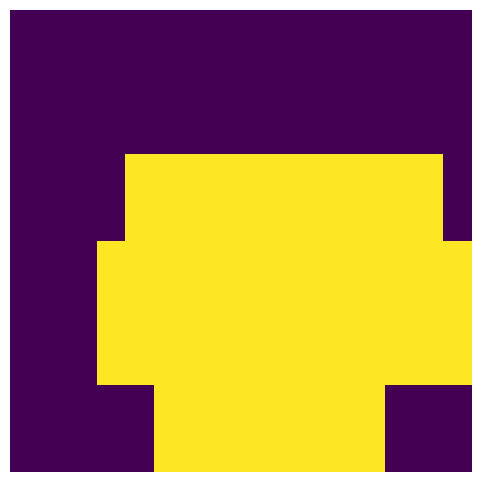

(1098910, 32, 32)


In [4]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class WaveguideDataset(Dataset):
    def __init__(self, h5_file):
        self.h5_file = h5py.File(h5_file, 'r')
        weights = self.h5_file['weight_train'][:]  # Shape: (N, 4)
        weight_sums = np.sum(weights, axis=1)  # Shape: (N,)
        patterns = self.h5_file['pattern_train'][:] # Shape: (N, 64, 64)
        mask = weight_sums < 100 # Mask that sorts for just good data 

        self.eigenmodes = self.h5_file['neff_train'][:]  # Shape: (N, 4)
        self.weights = weights[mask]  # Shape: (N, 4)
        self.paramss = self.h5_file['params_train'][:][mask]
        self.waveguides = np.array([quarter(p) for p in patterns])[mask]

    def __len__(self):
        return len(self.waveguides)

    def __getitem__(self, idx):
        eigenmode = self.eigenmodes[idx]  # (10, H, W)
        weight = self.weights[idx]  # (10,)
        params = self.paramss[idx]
        waveguide = self.waveguides[idx]  # (H, W)
        
        
        # Normalize (optional)
        eigenmode = torch.tensor(eigenmode, dtype=torch.float32)
        weight = torch.tensor(weight, dtype=torch.float32)
        params = torch.tensor(params, dtype=torch.float32)
        waveguide = torch.tensor(waveguide, dtype=torch.float32)

        return eigenmode, weight, params, waveguide

dataset = WaveguideDataset('train_test_split.h5')
load_item(dataset.__getitem__(2))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(dataset.waveguides.shape)

## Making Generator, Discriminator

### Remaking with Params

In [5]:
# class Generator(nn.Module):
#     def __init__(self, mode_dim=4, weight_dim=4, param_dim=4):
#         super(Generator, self).__init__()
#         self.input_dim = mode_dim + weight_dim + param_dim
#         self.init_res = 4  # 4x4 latent feature map to start

#         self.fc = nn.Sequential(
#             nn.Linear(self.input_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128 * self.init_res * self.init_res),
#             nn.ReLU()
#         )

#         self.upsample = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4 → 8
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 8 → 16
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),   # 16 → 32
#             nn.ReLU(),
#             nn.Conv2d(16, 1, kernel_size=3, padding=1),                        # Final output: [B, 1, 32, 32]
#             nn.Tanh()
#         )

#     def forward(self, eigenmodes, weights, params):
#         # Support numpy or torch input
#         if isinstance(eigenmodes, np.ndarray):
#             eigenmodes = torch.from_numpy(eigenmodes).float()
#         if isinstance(weights, np.ndarray):
#             weights = torch.from_numpy(weights).float()
#         if isinstance(params, np.ndarray):
#             params = torch.from_numpy(params).float()

#         device = next(self.parameters()).device
#         eigenmodes = eigenmodes.to(device)
#         weights = weights.to(device)
#         params = params.to(device)

#         x = torch.cat((eigenmodes, weights, params), dim=1)  # [B, 12]
#         x = self.fc(x)
#         x = x.view(-1, 128, self.init_res, self.init_res)    # [B, 128, 4, 4]
#         return self.upsample(x)                              # [B, 1, 32, 32]

# class Discriminator(nn.Module):
#     def __init__(self, input_channels=1):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Flatten(),
#             nn.Linear(128 * 8 * 8, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)

### Remake with Parameters included in Discriminator

In [6]:
class Generator(nn.Module):
    def __init__(self, cond_dim=8):
        """
        Generator that maps an input condition (eigenmodes and weights)
        to a waveguide image (32x32) and a set of 4 parameters.
        
        Args:
            cond_dim (int): Dimension of the condition input (default=8)
        """
        super(Generator, self).__init__()
        
        # First, process the condition through a fully connected network.
        # This "embedding" is used both to produce the image and the extra parameters.
        self.fc = nn.Sequential(
            nn.Linear(cond_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.ReLU(True),
        )
        # For the waveguide branch, map the 512-dimensional feature vector to a feature map:
        # We choose 64 channels with a spatial size of 4x4 (64*4*4 = 1024 features).
        self.fc_img = nn.Linear(512, 64 * 4 * 4)
        
        # Then use a series of ConvTranspose2d layers to upscale to 32x32.
        self.deconv = nn.Sequential(
            # Upsample from 4x4 to 8x8
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            # Upsample from 8x8 to 16x16
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            # Upsample from 16x16 to 32x32; output 1 channel for the binary image.
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Ensures the output is in the range [0,1].
        )
        
        # A branch for predicting the extra four parameters.
        self.fc_params = nn.Sequential(
            nn.Linear(512, 32),
            nn.ReLU(True),
            nn.Linear(32, 4)  # Output: [wavelength, lattice, n_atom, n_lattice]
        )
    
    def forward(self, cond):
        """
        Forward pass of Generator.
        
        Args:
            cond (torch.Tensor): Tensor of shape (batch_size, 8) representing the four eigenmodes and four weights.
        
        Returns:
            waveguide (torch.Tensor): Tensor of shape (batch_size, 1, 32, 32) representing the waveguide image.
            params (torch.Tensor): Tensor of shape (batch_size, 4) representing the additional parameters.
        """
        x = self.fc(cond)  # Process condition into a 512-dim feature vector.
        
        # Generate image: 
        img_features = self.fc_img(x)
        # Reshape to (batch_size, 64, 4, 4)
        img_features = img_features.view(-1, 64, 4, 4)
        waveguide = self.deconv(img_features)
        waveguide = (waveguide >= 0.5).float()
        # Generate the extra parameters via a separate branch.
        params = self.fc_params(x)
        
        return waveguide, params


class Discriminator(nn.Module):
    def __init__(self, cond_dim=8):
        """
        Discriminator that judges whether a given tuple (waveguide image, extra parameters, and condition)
        comes from the data distribution or from the generator.
        
        Args:
            cond_dim (int): Dimension of the condition input (default=8)
        """
        super(Discriminator, self).__init__()
        
        # Convolutional branch to process the waveguide image (assumed to have shape (1, 32, 32)).
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),  # Output: (16, 16, 16)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1), # Output: (32, 8, 8)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # Output: (64, 4, 4)
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Fully connected layer to further process flattened image features.
        self.fc_image = nn.Linear(64 * 4 * 4, 128)
        
        # Process the extra parameters (4-D vector).
        self.fc_params = nn.Sequential(
            nn.Linear(4, 16),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Process the condition input (8-D vector).
        self.fc_cond = nn.Sequential(
            nn.Linear(cond_dim, 16),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Combine all features to produce the final decision.
        self.fc_final = nn.Sequential(
            nn.Linear(128 + 16 + 16, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Outputs a probability.
        )
    
    def forward(self, waveguide, params, cond):
        """
        Forward pass of Discriminator.
        
        Args:
            waveguide (torch.Tensor): Tensor of shape (batch_size, 1, 32, 32).
            params (torch.Tensor): Tensor of shape (batch_size, 4).
            cond (torch.Tensor): Tensor of shape (batch_size, 8) with the eigenmodes/weights.
        
        Returns:
            validity (torch.Tensor): Tensor of shape (batch_size, 1) representing the probability of being real.
        """
        batch_size = waveguide.size(0)
        x_img = self.cnn(waveguide)
        # Flatten image features.
        x_img = x_img.view(batch_size, -1)
        x_img = self.fc_image(x_img)
        
        # Embed extra parameters.
        x_params = self.fc_params(params)
        
        # Embed the condition vector.
        x_cond = self.fc_cond(cond)
        
        # Concatenate the three representations.
        x = torch.cat([x_img, x_params, x_cond], dim=1)
        validity = self.fc_final(x)
        
        return validity

# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    # Suppose we have a batch size of 16.
    batch_size = 16
    # Create dummy condition input (4 eigenmodes + 4 weights = 8 features per sample)
    cond = torch.randn(batch_size, 8)
    
    # Initialize the generator and forward propagate.
    netG = Generator(cond_dim=8)
    fake_waveguide, fake_params = netG(cond)
    print("Generator output:")
    print("  waveguide shape:", fake_waveguide.shape)  # Should be (16, 1, 32, 32)
    print("  params shape:", fake_params.shape)        # Should be (16, 4)
    
    # Now initialize the discriminator.
    netD = Discriminator(cond_dim=8)
    # Here, we use the generated outputs along with the same condition.
    validity = netD(fake_waveguide, fake_params, cond)
    print("Discriminator output shape:", validity.shape)  # Should be (16, 1)


Generator output:
  waveguide shape: torch.Size([16, 1, 32, 32])
  params shape: torch.Size([16, 4])
Discriminator output shape: torch.Size([16, 1])


### Intializing Models and Optimizers

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 0.0002

optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

### Training the GAN

#### V1

In [8]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# generator = Generator().to(device)
# discriminator = Discriminator().to(device)

# criterion = nn.BCELoss()
# optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# epochs = 100

# for epoch in range(epochs):
#     start_time = time.perf_counter()
#     for eigenmodes, weights, params, real_waveguides in dataloader:
#         eigenmodes, weights, params, real_waveguides = eigenmodes.to(device), weights.to(device),  params.to(device), real_waveguides.to(device)

#         batch_size = eigenmodes.size(0)
#         real_labels = torch.ones(batch_size, 1).to(device)
#         fake_labels = torch.zeros(batch_size, 1).to(device)

#         # Train Discriminator
#         optimizer_d.zero_grad()
#         # print(real_waveguides.unsqueeze(1).shape)
#         real_outputs = discriminator(real_waveguides.unsqueeze(1))
#         real_loss = criterion(real_outputs, real_labels)


#         # print(eigenmodes.shape[1])
#         # print(weights.shape)
#         fake_waveguides = generator(eigenmodes, weights, params)
#         # print(fake_waveguides.size)
#         fake_outputs = discriminator(fake_waveguides.detach())
#         fake_loss = criterion(fake_outputs, fake_labels)

#         d_loss = real_loss + fake_loss
#         d_loss.backward()
#         optimizer_d.step()

#         # Train Generator
#         optimizer_g.zero_grad()
#         fake_outputs = discriminator(fake_waveguides)
#         g_loss = criterion(fake_outputs, real_labels)  # Want G to fool D
#         g_loss.backward()
#         optimizer_g.step()

#     print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")
#     end_time = time.perf_counter()
#     execution_time = end_time - start_time
#     print(f"The Epoch took {execution_time:.4f} seconds to run.")

# print("Training complete!")


#### V2

Training with new Generator and Descriminator

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Assume Generator and Discriminator have been defined previously and imported.
# Generator takes an 8-D condition vector and outputs:
#    - waveguide (batch_size, 1, 32, 32)
#    - parameters (batch_size, 4)
# Discriminator takes:
#    - waveguide (batch_size, 1, 32, 32)
#    - parameters (batch_size, 4)
#    - condition (batch_size, 8)
# and outputs a probability.

# Set device and hyperparameters.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.0002
epochs = 100

# Instantiate the networks.
generator = Generator(cond_dim=8).to(device)
discriminator = Discriminator(cond_dim=8).to(device)

# Define adversarial loss.
criterion_adv = nn.BCELoss()

# (Optional) Define a regression loss for the parameters.
criterion_param = nn.MSELoss()

# Optimizers for both networks.
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop.
# Gradient N
# Figure out correct enviroment
# Plot loss function during training ( to determine convergence )
# No gradient explosion/vanishment
for epoch in range(epochs):
    start_time = time.perf_counter()
    
    for eigenmodes, weights, params, real_waveguides in dataloader:
        # Move data to the appropriate device.
        eigenmodes = eigenmodes.to(device)      # shape: (batch_size, 4)
        weights = weights.to(device)            # shape: (batch_size, 4)
        params = params.to(device)              # shape: (batch_size, 4)
        real_waveguides = real_waveguides.to(device)  # shape: (batch_size, 32, 32)
        
        # Build the condition vector: concatenate eigenmodes and weights.
        cond = torch.cat([eigenmodes, weights], dim=1)  # shape: (batch_size, 8)
        print(cond.shape)
        batch_size = eigenmodes.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # -------------------------
        # Train Discriminator
        # -------------------------
        optimizer_d.zero_grad()
        
        # Process real data:
        # Unsqueeze the channel dimension for the waveguide image.
        real_outputs = discriminator(real_waveguides.unsqueeze(1), params, cond)
        real_loss = criterion_adv(real_outputs, real_labels)
        
        # Generate fake data with the generator.
        fake_waveguides, fake_params = generator(cond)
        fake_outputs = discriminator(fake_waveguides, fake_params, cond)
        fake_loss = criterion_adv(fake_outputs, fake_labels)
        
        # Combine discriminator losses and update.
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()
        
        # -------------------------
        # Train Generator
        # -------------------------
        optimizer_g.zero_grad()
        
        # Re-generate fake data (to ensure proper gradients flow).
        fake_waveguides, fake_params = generator(cond)
        fake_outputs = discriminator(fake_waveguides, fake_params, cond)
        
        # Adversarial loss: try to have the discriminator label fakes as real.
        g_loss_adv = criterion_adv(fake_outputs, real_labels)
        
        # (Optional) Parameter loss: force the predicted parameters to match the ground truth.
        g_loss_param = criterion_param(fake_params, params)
        # A weighting factor can be used to balance the two losses.
        lambda_param = 10.0
        
        g_loss = g_loss_adv + lambda_param * g_loss_param
        g_loss.backward()
        optimizer_g.step()
    
    end_time = time.perf_counter()
    epoch_time = end_time - start_time
    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
    print(f"Epoch took {epoch_time:.4f} seconds.")

print("Training complete!")


torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([32, 8])


KeyboardInterrupt: 

### New training with plotting to track model

working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


KeyboardInterrupt: 

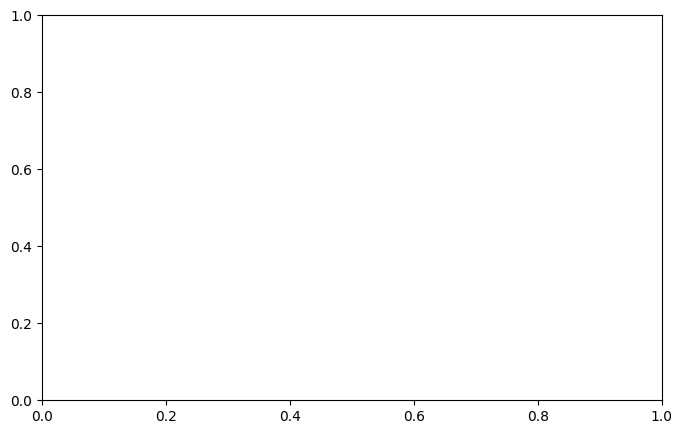

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import matplotlib
matplotlib.use('TkAgg') # Or 'QtAgg', 'WXAgg'
import matplotlib.pyplot as plt

# Assume Generator, Discriminator, dataloader, (and optional val_dataloader) are defined above.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 2e-4
epochs = 100
lambda_param = 10.0

# Instantiate models and losses
generator     = Generator(cond_dim=8).to(device)
discriminator = Discriminator(cond_dim=8).to(device)
criterion_adv   = nn.BCELoss()
criterion_param = nn.MSELoss()

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Prepare lists for logging
train_d_losses = []
train_g_losses = []
# val_d_losses   = []
# val_g_losses   = []

# Set up interactive plotting
plt.ion()
fig, ax = plt.subplots(figsize=(8,5))

for epoch in range(1, epochs+1):
    start = time.perf_counter()
    d_epoch = []
    g_epoch = []

    for em, wts, prm, real_wg in dataloader:
        bs = em.size(0)
        real_lbl = torch.ones(bs,1,device=device)
        fake_lbl = torch.zeros(bs,1,device=device)
        print('working')
        em, wts, prm = em.to(device), wts.to(device), prm.to(device)
        real_wg = real_wg.to(device).unsqueeze(1)  # (B,1,32,32)
        cond    = torch.cat([em, wts], dim=1)

        # — Train Discriminator —
        optimizer_d.zero_grad()
        real_out = discriminator(real_wg, prm, cond)
        d_real   = criterion_adv(real_out, real_lbl)

        fake_wg, fake_prm = generator(cond)
        fake_out          = discriminator(fake_wg, fake_prm, cond)
        d_fake            = criterion_adv(fake_out, fake_lbl)

        d_loss = d_real + d_fake
        d_loss.backward()
        optimizer_d.step()

        # — Train Generator —
        optimizer_g.zero_grad()
        fake_wg2, fake_prm2 = generator(cond)
        fake_out2           = discriminator(fake_wg2, fake_prm2, cond)

        g_adv   = criterion_adv(fake_out2, real_lbl)
        g_param = criterion_param(fake_prm2, prm)
        g_loss  = g_adv + lambda_param * g_param

        g_loss.backward()
        optimizer_g.step()

        d_epoch.append(d_loss.item())
        g_epoch.append(g_loss.item())

    # Average losses this epoch
    avg_d = np.mean(d_epoch)
    avg_g = np.mean(g_epoch)
    train_d_losses.append(avg_d)
    train_g_losses.append(avg_g)


    elapsed = time.perf_counter() - start
    print(f"Epoch {epoch:3d}/{epochs} — D: {avg_d:.4f}, G: {avg_g:.4f} — {elapsed:.1f}s")

    # — Update live plot —
    ax.clear()
    ax.plot(train_d_losses, label='Train D Loss')
    ax.plot(train_g_losses, label='Train G Loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('GAN Losses (Live)')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.pause(0.1)  # small pause to render

plt.ioff()
plt.show()


### Visualizing Waveguide Patterns

[4.1121531e+00 6.1247456e-01 0.0000000e+00 0.0000000e+00 5.3091198e+01
 4.6695271e+01 2.7151153e-05 6.7542346e-06]
<class 'torch.Tensor'>


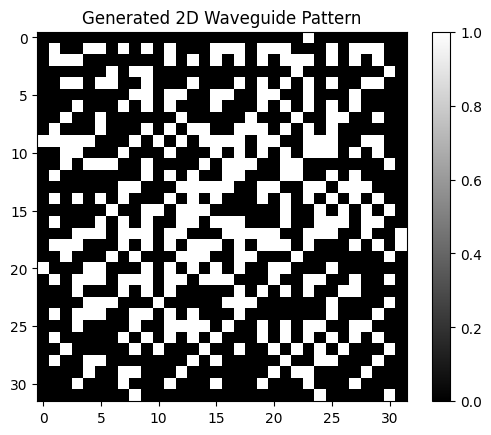

In [10]:
def generate_waveguide(generator, eigenmodes_weights):
    generator.eval()
    eigenmodes_weights = torch.tensor(eigenmodes_weights, dtype=torch.float32).unsqueeze(0).to(device)
    # weights = torch.tensor(weights, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        generated_waveguide = generator(eigenmodes_weights)
    return generated_waveguide
    # return generated_waveguide[0, 0]  # Extract single output channel

# Example usage
eigenmodes_example = dataset[0][0].numpy()  # Use first sample
weights_example = dataset[0][1].numpy()
cond = np.concatenate((eigenmodes_example, weights_example))
print(cond)
generated_waveguide, params = generate_waveguide(generator, cond)
print(type(generated_waveguide))
plt.imshow(generated_waveguide.squeeze(0).squeeze(0), cmap='gray')
plt.colorbar()
plt.title("Generated 2D Waveguide Pattern")
plt.show()

In [2]:
import matplotlib
matplotlib.use('TkAgg') # Or 'QtAgg', 'WXAgg'
import matplotlib.pyplot as plt
plt.ion()

fig, ax = plt.subplots(figsize=(8,5))
bruh = []
bruh2 = []
for i in range(0,100):
    bruh.append(i)
    bruh2.append(i)
    ax.clear()
    ax.plot(bruh, label='Train D Loss')
    ax.plot(bruh2, label='Train G Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('GAN Losses (Live)')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.pause(0.1)

KeyboardInterrupt: 